In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x585f6000 @  0x7fb2825a82a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive as drive1
import statistics
import os,sys
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def get_file_from_drive(folder_id, file_name):
    file_list = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == file_name:
            return file['id']
                             
                              
def upload_data_system():
    drive_folder_id='1ULUg-0_gqrdbJdCRAh-ZtnA9e54ZAprr'
    alexnet_downloaded=drive.CreateFile({'id':get_file_from_drive(drive_folder_id,'AlexNet.py')})
    alexnet_downloaded.GetContentFile('AlexNet.py')
    drive_folder_id='11JBUDD89e8J9_ZdWkGKXG0OWd0YM8Fep'
    prefix='train_batch_'
    for i in range(1,22,1):
        #print(i)
        temp_fn=prefix+str(i)+'_x.npy'
        temp_lfn=prefix+str(i)+'_y.pkl'
        file_downloaded=drive.CreateFile({'id':get_file_from_drive(drive_folder_id,temp_fn)})
        file_downloaded.GetContentFile(temp_fn)
        label_downloaded=drive.CreateFile({'id':get_file_from_drive(drive_folder_id,temp_lfn)})
        label_downloaded.GetContentFile(temp_lfn)
    prefix='valid_batch_'    
    for i in range(1,7,1):
        #print(i)
        temp_fn=prefix+str(i)+'_x.npy'
        temp_lfn=prefix+str(i)+'_y.pkl'
        file_downloaded=drive.CreateFile({'id':get_file_from_drive(drive_folder_id,temp_fn)})
        file_downloaded.GetContentFile(temp_fn)
        label_downloaded=drive.CreateFile({'id':get_file_from_drive(drive_folder_id,temp_lfn)})
        label_downloaded.GetContentFile(temp_lfn)
    
                             
upload_data_system()

'''for f in os.listdir('.'):
    if os.path.isfile(f):
        print(f)
'''

print('Uploaded all data in file system!')
        

Uploaded all data in file system!


In [0]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
#import os, sys
import pickle
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
import torch.optim as optim
import matplotlib.pyplot as plt
from AlexNet import AlexNet
import time


In [0]:
N_CLASSES=15
BATCH_SIZE=64
num_epochs=10
learning_rate=0.001
os.environ['CUDA_VISIBLE_DEVICES']="0"
print(torch.cuda.get_device_name(0))


Tesla K80


In [0]:
def compute_AUCs(gt, pred):
	
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

In [0]:
class ChestXRayDataSet(Dataset):
    def __init__(self,train_or_valid,data_path,label_path,transform=None):
        self.train_or_valid=train_or_valid
        if train_or_valid=="train":
            self.X=np.uint8(np.load(data_path)*255*255)
            with open(label_path,"rb") as f:
                self.y=pickle.load(f)
            sub_bool=(self.y.sum(axis=1)!=0)
            #print('sub_bool',sub_bool)
            self.y=self.y[sub_bool,:]
            self.X=self.X[sub_bool,:]
        else:
            self.X=np.uint8(np.load(data_path)*255*255)
            with open(label_path,"rb") as f:
                self.y=pickle.load(f)
        self.label_weight_pos = (len(self.y)-self.y.sum(axis=0))/len(self.y)
        self.label_weight_neg = (self.y.sum(axis=0))/len(self.y)                
        self.transform=transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self,index):
        current_X = np.tile(self.X[index],3)
        #item=self.X[index]
        label=self.y[index]
        label_inverse = 1- label
        weight = np.add((label_inverse * self.label_weight_neg),(label * self.label_weight_pos))
        if self.transform:
            item=self.transform(current_X)
        return item,torch.from_numpy(label).type(torch.FloatTensor),torch.from_numpy(weight).type(torch.FloatTensor)


Using device: Tesla K80



Epoch 0

Starting training phase...



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


% of training completed: 100

Starting Validation phase

% of validation completed: 100

Time taken for epoch #1 is: 14 minutes
The average AUROC is 0.618
The AUROC of Atelectasis is 0.707723496835443
The AUROC of Cardiomegaly is 0.6997276916631755
The AUROC of Consolidation is 0.7749543265238332
The AUROC of Edema is 0.739788513373419
The AUROC of Effusion is 0.715761736356702
The AUROC of Emphysema is 0.3830882352941176
The AUROC of Fibrosis is 0.4160610465116279
The AUROC of Hernia is 0.8546762589928057
The AUROC of Infiltration is 0.621491294858129
The AUROC of Mass is 0.534180602006689
The AUROC of No Finding is 0.662166413031465
The AUROC of Nodule is 0.6441692073170732
The AUROC of Pleural_Thickening is 0.423113575327038
The AUROC of Pneumonia is 0.5076823548439269
The AUROC of Pneumothorax is 0.5824060233626751
Epoch 0 training loss: 0.241


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:226: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





Epoch 1

Starting training phase...

% of training completed: 100

Starting Validation phase

% of validation completed: 100

Time taken for epoch #2 is: 14 minutes
The average AUROC is 0.500
The AUROC of Atelectasis is 0.48595727848101267
The AUROC of Cardiomegaly is 0.47020318391286137
The AUROC of Consolidation is 0.5067264573991032
The AUROC of Edema is 0.5065312046444121
The AUROC of Effusion is 0.49362041467304624
The AUROC of Emphysema is 0.5267922794117648
The AUROC of Fibrosis is 0.5065406976744186
The AUROC of Hernia is 0.4949640287769784
The AUROC of Infiltration is 0.49413735343383586
The AUROC of Mass is 0.5069230769230769
The AUROC of No Finding is 0.5056153983489624
The AUROC of Nodule is 0.5007621951219512
The AUROC of Pleural_Thickening is 0.4948453608247423
The AUROC of Pneumonia is 0.4949053857350801
The AUROC of Pneumothorax is 0.5067264573991032
Epoch 1 training loss: 0.243



Epoch 2

Starting training phase...

% of training completed: 100

Starting Validation

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


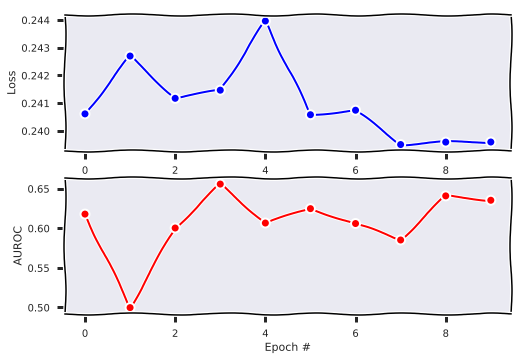

In [9]:
if __name__=='__main__':
    
    if torch.cuda.is_available()==False:
        sys.exit(0)
    else:
        device=torch.device("cuda:0")

    cwd=os.getcwd()
    print('Using device:',torch.cuda.get_device_name(0))
    '''parser=argparse.ArgumentParser()
    parser.add_argument("--dataset",action="store",required=True,help='get path to dataset',dest='dataset')
    parser.add_argument("--output",action="store",required=True,help='get path to output',dest='output')
    args=parser.parse_args()
    dataset=os.path.join(cwd,args.__dict__['dataset'])
    print(dataset)
    output=os.path.join(cwd,args.__dict__['output'])
    print(output)'''
    epoch_losses=[]
    batch_losses=[]
    all_auroc_avgs=[]

    
    for epoch in range(num_epochs):
        epoch_start_time=time.time()
        print("\n\n\nEpoch",epoch)
        #print('Start time:',epoch_start_time)

        data_files=sorted([x for x in os.listdir(cwd) if x.startswith('train') and x.endswith('.npy')])
        batch_len=len(data_files)
        label_files=sorted([x for x in os.listdir(cwd) if x.startswith('train') and x.endswith('.pkl')])
        '''for i in range(batch_len):
            print(data_files[i],label_files[i])
        '''
        #print(len(data_files))
        #print(len(label_files))
        #epoch_loss=0.0
        intermediate_model_filepath=os.path.join(cwd,'intermediate_model.pkl')
        model=AlexNet(N_CLASSES).cuda()
        model = torch.nn.DataParallel(model).cuda()
        temp_losses=[]
        epoch_data_len=0
        
        
        
        ############## Training data #########################
        
        #'''
        print('\nStarting training phase...\n')
        for i in range(len(data_files)):
            #print(data_files[i],label_files[i])
            #print("Processing",data_files[i])
            data_file=os.path.join(cwd,data_files[i])
            label_file=os.path.join(cwd,label_files[i])
            dataset2=ChestXRayDataSet("train",data_file,label_file,
                    transform=transforms.Compose([
                        transforms.ToPILImage(),
                        transforms.RandomCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.224])
                        ]))

            augment_img=[]
            augment_label=[]
            augment_weight=[]
            for k in range(1):
                for j in range(len(dataset2)):
                    single_img,single_label,single_weight=dataset2[j]
                    augment_img.append(single_img)
                    augment_label.append(single_label)
                    augment_weight.append(single_weight)
                    
            
            #print("Data Augmentation done OK")
            #print("Length of augmented data:",len(augment_label))

            #shuffle data
            permuted_order=torch.randperm(len(augment_label))
            #print(type(augment_img),type(augment_label))
            augment_img=torch.stack(augment_img)[permuted_order]
            augment_label=torch.stack(augment_label)[permuted_order]
            augment_weight=torch.stack(augment_weight)[permuted_order]

            #======= start training =======#
            #print("Training...")

            cudnn.benchmark=True
            #criterion=nn.CrossEntropyLoss()
            criterion=nn.BCEWithLogitsLoss()
            optimizer=optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999))

            intermediate_model_filepath=os.path.join(cwd,'intermediate_model.pkl')

            #Check for intermediate model state
            if os.path.exists(intermediate_model_filepath):
                checkpoint=torch.load('intermediate_model.pkl')
                model.load_state_dict(checkpoint['state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer'])
            else:
                model=AlexNet(N_CLASSES).cuda()
            #set model to train mode
            model.train()
            total_length=len(augment_img)
            epoch_data_len+=total_length
            
            running_loss=0.0

            for k in range(0,total_length,BATCH_SIZE):
                optimizer.zero_grad()
                sub_input=[]
                sub_label=[]
                if k+BATCH_SIZE>total_length:
                    sub_input=augment_img[k:]
                    sub_label=augment_label[k:]
                    sub_weights=augment_weight[k:]
                else:
                    sub_input=augment_img[k:k+BATCH_SIZE]
                    sub_label=augment_label[k:k+BATCH_SIZE]
                    sub_weights=augment_weight[k:k+BATCH_SIZE]

                sub_input,sub_label=Variable(sub_input.cuda()),Variable(sub_label.cuda())
                sub_weights=Variable(sub_weights.cuda())

                #forward + backward + optimizer update

                output=model(sub_input)
                #loss=criterion(output,torch.max(sub_label,1)[1])
                loss=criterion(output,sub_label)
                loss.backward()
                optimizer.step()
                running_loss+=loss.data[0]

            batch_loss=running_loss/total_length
            '''print(running_loss)
            print(total_loss)
            print(batch_loss)'''
            compavg=int((i+1)/(batch_len)*100)
            sys.stdout.write('\r'+"% of training completed: "+str(compavg))
            sys.stdout.flush()
            temp_losses.append(running_loss)
            
            
            #Save model for use in next batch
            state = {'state_dict':model.state_dict(),
                    'optimizer':optimizer.state_dict(),
                    'loss':batch_loss,}
            torch.save(state,'intermediate_model.pkl')
            
            
        
        #'''
        
        #========= validation ==========#
        
        print("\n\nStarting Validation phase\n")

        data_files=sorted([x for x in os.listdir(cwd) if x.startswith('valid') and x.endswith('.npy')])
        label_files=sorted([x for x in os.listdir(cwd) if x.startswith('valid') and x.endswith('.pkl')])
        batch_len=len(label_files)
        #print(data_files)
        #print(label_files)
        #print(len(label_files))

        for i in range(len(data_files)):
            #print("Training",data_files[i],label_files[i])
            #Initialize validation set
            data_file=os.path.join(cwd,data_files[i])
            label_file=os.path.join(cwd,label_files[i])
            dataset3=ChestXRayDataSet("valid",data_file,label_file,
                    transform=transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.224])
                            ]))
            data_loader=DataLoader(dataset=dataset3,batch_size=16,shuffle=True)

            #print("Evaluating...")
            #switch to eval mode 
            model.eval()
            gt = torch.FloatTensor()
            gt = gt.cuda()
            pred = torch.FloatTensor()
            pred = pred.cuda()

            for (image,label,weight) in data_loader:
                label = label.cuda()
                gt = torch.cat((gt, label), 0)
                image=Variable(image.view(-1,3,224,224).cuda())
                output=model(image)
                pred = torch.cat((pred, output.data), 0)

            compavg=int((i+1)/(batch_len)*100)
            sys.stdout.write("\r% of validation completed: "+str(compavg))
            sys.stdout.flush()
                

        #Print statistics
        #print("End time:",time.time())
        time_taken=int(time.time()-epoch_start_time)
        time_taken=time_taken//60
        print('\n\nTime taken for epoch #'+str(epoch+1)+' is: '+str(time_taken)+' minutes')
        
        CLASS_NAMES = ['Atelectasis', 'Cardiomegaly','Consolidation','Edema','Effusion','Emphysema','Fibrosis','Hernia','Infiltration','Mass','No Finding','Nodule','Pleural_Thickening','Pneumonia', 'Pneumothorax']
        #print(gt.size(),pred.size())
        AUROCs = compute_AUCs(gt, pred)
        AUROC_avg = np.array(AUROCs).mean()
        all_auroc_avgs.append(AUROC_avg)
        print('The average AUROC is {AUROC_avg:.3f}'.format(AUROC_avg=AUROC_avg))
        for i in range(N_CLASSES):
            print('The AUROC of {} is {}'.format(CLASS_NAMES[i], AUROCs[i]))
    
		
        #print('[%d] loss: %.3f' % (epoch, running_loss / 715 ))
        
        #Save model
        #model_file_name='AlexNet_aug1_noWeight_'+str(epoch+1)+'.pkl'
        '''torch.save(model.state_dict(),model_file_name)
        model_file = drive.CreateFile({'title' : model_file_name})
        model_file.SetContentFile(model_file_name)
        model_file.Upload()
        '''
        avg=0.0
        for i in range(len(temp_losses)):
            #print(temp_losses[i])
            tavg=temp_losses[i].data[0]
            avg=avg+tavg
        #avg=avg/len(temp_losses)
        #print(avg)
        #print(epoch_data_len)
        epoch_data_len=epoch_data_len/BATCH_SIZE
        avg=avg/epoch_data_len
        print('Epoch %d training loss: %.3f' % (epoch,avg))
        batch_losses.append(avg)

        #Save model for use in next batch
        state = {'state_dict':model.state_dict(),
                'optimizer':optimizer.state_dict(),
                'loss':avg,}

        torch.save(state,'AlexNet_Epoch_'+str(epoch+1)+'.pkl')
        
        model.train()
        
        if os.path.exists(intermediate_model_filepath):
            os.remove(intermediate_model_filepath)
            
        torch.cuda.empty_cache()
            
    #Visualize losses
    #print(batch_losses)
    print('\n\nVisualizing accuracy and loss')
    plt.xkcd()    
    plt.subplot(211)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.plot(batch_losses,marker='o',color='b')
    plt.subplot(212)
    plt.xlabel('Epoch #')
    plt.ylabel('AUROC')
    plt.plot(all_auroc_avgs,marker='o',color='r')
    #plt.show()
    plt.savefig('Epoch_AUROC_and_Losses')
        